# Outline

### Figures of Interest to Replicate

Figure 2: UMAPs by donor
- 4 UMAPs showing total transcriptome clustering by donor

Figure 5: Pathway Analysis of specific cluster
- cluster is identified from comparing two host-only clustering UMAPs
- UMAPs are uninfected cells and all cells

### Steps to Prepare All Data:
- read in the data per donor
- demultiplex the donor data then remove doublets and negatives; AND separate the combined donor 3 and donor 4 data
- QC control for all donor data -- results in d#_adata_qc, 4 AnnData Objects
- add important columns to each of these AnnData objects for future analysis (species and pct_parasite)
- datasets separated by donor = d#_adata_qc used for subsetting and these are used for figure 2 specifc UMAPs --> qc_data = list(d1_adata_qc, d2_adata_qc, d3_adata_qc, d4_adata_qc)
- create subsets for figure 5: extract host-only transctips from each donor by species column
- leaves datasets of host_only = list(d1_human, d2_human, d3_human, d4_human)

### Steps to Prepare Data for Figure 2 Plotting:
- data for fig 2: list(d1_adata_qc, d2_adata_qc, d3_adata_qc, d4_adata_qc)
- normalize
- unique_index
- find HVGs
- create list of HVGs
- subset each of the 4 AnnData objects to only include the HVGs
- integrate all 4 into 1 (integrate and then concat)
- scale this 1 AnnData object

### Steps to Prepare Data for Figure 5 Plotting:
- data for fig 5: list(d1_human, d2_human, d3_human, d4_human)
- normalize
- unique_index
- find HVGs
- create list of HVGs
- subset each of the 4 AnnData objects to only include the HVGs
- integrate all 4 into 1 (integrate and then concat)
- scale this 1 AnnData object

### PCA then UMAP Visualization:
- for each scaled and integrated AnnData object for Fig 2 or Fig 5......
- calculate PCA, neighbors, UMAP, and cluster with leiden on the scaled, integrated data
- maintain number of PCs and resolution that was used in the paper
- fig 2 uses 1-41 PCs at a resolution of 0.4 to get 12 clusters
- then for the fig 2, the integrated anndata can be separated by donor once again
- processing of the host-only transcripts ises 1-43 PCs at a resolution of 0.2 to get 9 clusters
- the host_transcript only data was subset right before plotting to obtain a control dataset that was only cells that were considered uninfected.
- run sc.pl.umap

### Enrichment Analysis:
- Identify cluster from figure 5 umaps showing the most difference
- isolate the cells and their genes, filtering for FC > 1.5
- run EnrichR using Molecular Signatures Hallmark 2020
- make bar chart ranked by p-vales


----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------


In [1]:
# imports
import pandas as pd
import scanpy as sc
import gzip
import scipy.io
import scanorama
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm

### Read in Data

In [2]:
def read_files(file_name):
    '''
    This function reads the tsv files holding barcodes and features, and the matrix data downloaded from GEO
    
    input: file ID as str
    output: dataframe for barcodes and for features, sparse matrix for matrix
    
    '''
    barcodes = pd.read_csv(f"data/GSM829724{file_name}_barcodes.tsv.gz", sep='\t', header=None)
    features = pd.read_csv(f"data/GSM829724{file_name}_features.tsv.gz", sep='\t', header=None)
    matrix = scipy.io.mmread(f"data/GSM829724{file_name}_matrix.mtx.gz")

    return matrix, barcodes, features    

In [3]:
# file_ids = ['3_Donor_1', '4_Donor_2', '5_Donor_3_4']

d1_matrix, d1_barcodes, d1_features = read_files('3_Donor_1')
d2_matrix, d2_barcodes, d2_features = read_files('4_Donor_2')
d34_matrix, d34_barcodes, d34_features = read_files('5_Donor_3_4')


### Demultiplex, remove doublets & negatives, and separate donors 3 & 4

In [4]:
### demultiplex based on their hashing antibodies

def demultiplex(matrix, barcodes, features, donor): # add timepoint features data to the adata object for demultiplex
    '''
    This function demultiplexes the data: 
    - separates antibody capture feature from gene expression feature
    - subsets data based on the separated features
    - runs hashsolo from scanpy for singlet, doublet, or negative cells
    - removes doublet cells (more than one hastag antibody) and negative cells (no hashtag antibody)   
    - and fixes naming from the original data files
    '''
    # combine all data needed for demultiplex into one place
    adata = sc.AnnData(
        X=matrix.T.tocsr(),
        obs=pd.DataFrame(index=barcodes[0]),
        var=pd.DataFrame({
            'gene_ids': features[0].values,
            'gene_names': features[1].values,
            'feature_types': features[2].values
        }, index=features[1].values)
    )
    
    # separate gene expression from antibody capture
    gene_mask = adata.var['feature_types'] == 'Gene Expression'
    hto_mask = adata.var['feature_types'] == 'Antibody Capture'
    adata_gex = adata[:, gene_mask].copy()
    hto_df = adata[:, hto_mask].copy().to_df()
    
    # creates new column labeled by antibody hashtag and fills in the counts
    for col in hto_df.columns:
        adata_gex.obs[col] = hto_df[col].values
    
    # run hashsolo -- the demultiplexing algorithm -- to classify cells as singlet, doublet, or negative
    sc.external.pp.hashsolo(adata_gex, hto_df.columns)
    
    # create hashtag mapping based on the actual features file (need to separate donors 3 and 4)
    antibody_features = features[features[2] == 'Antibody Capture']
    hashtag_mapping = {}
   
    for idx, row in antibody_features.iterrows():
        timepoint_label = row[0]  # different namings across samples e.g. 1dpi vs 24hpi
        hashtag_name = row[1]     #  full antibody name
        
        # determine donor based on function parameter and label
        if donor == 'Donor3_4':
            # separate hashtags in donor 3 from donor 4
            if timepoint_label.startswith('D3_'):
                d = 'Donor3'
                tp_raw = timepoint_label.replace('D3_', '')
            elif timepoint_label.startswith('D4_'):
                d = 'Donor4'
                tp_raw = timepoint_label.replace('D4_', '')
                
        else: # no need to separate the hashtags
            d = donor
            tp_raw = timepoint_label
        
        # standardize timepoint names (handle all variations)
        timepoint_standardization = {
            # Donor 1 format
            'Ctrl': 'Ctrl',
            '1dpi': '24hpi',
            '2dpi': '48hpi',
            '3dpi': '72hpi',
            # Donor 2 format
            '3hpi': '3hpi',
            '12hpi': '12hpi',
            # Donor 3/4 format
            'D3_ctrl': 'Ctrl',
            'D3_1dpi': '24hpi',
            'D3_2dpi': '48hpi',
            'D4_ctrl': 'Ctrl',
            'D4_1dpi': '24hpi',
            'D4_2dpi': '48hpi',
        }
        
        # replace timepoint labels with consistently formatted names
        tp = timepoint_standardization.get(timepoint_label, tp_raw)
        
        hashtag_mapping[hashtag_name] = (d, tp) # use consistent name in the mapping
       
    # apply mapping
    def get_donor(classification):
        if classification in hashtag_mapping: # is mapped to one antibody
            return hashtag_mapping[classification][0]
        return classification  # if doublet or negative, return doublet/negative to be filtered out
    
    def get_timepoint(classification):
        if classification in hashtag_mapping: # if mapped to one anitbody then return the timepoint
            return hashtag_mapping[classification][1]
        return None  # return nothing for doublet or negative

    # create new columns to idenity donor and timepoint
    adata_gex.obs['donor'] = adata_gex.obs['Classification'].apply(get_donor)
    adata_gex.obs['timepoint'] = adata_gex.obs['Classification'].apply(get_timepoint)
    
    # filter out doublets and negatives
    adata_filtered = adata_gex[
        ~adata_gex.obs['Classification'].isin(['Doublet', 'Negative'])
    ].copy()
    
    sc.pp.filter_genes(adata_filtered, min_cells=1)
    
    return adata_filtered

In [5]:
# call demultiplex
d1_adata_filtered = demultiplex(d1_matrix, d1_barcodes, d1_features, 'Donor1')
d2_adata_filtered = demultiplex(d2_matrix, d2_barcodes, d2_features, 'Donor2')
d34_adata_filtered = demultiplex(d34_matrix, d34_barcodes, d34_features,'Donor3_4')

# seaparate on 'donor' column for d34
d3_adata_filtered = d34_adata_filtered[d34_adata_filtered.obs['donor'] == "Donor3"].copy()
d4_adata_filtered = d34_adata_filtered[d34_adata_filtered.obs['donor'] == "Donor4"].copy()

/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### QC

In [6]:
### remove low quality cells

def remove_low_quality(adata_filtered, features_range, counts_range, percent):
    '''
    This function takes the adata_filtered object, and filters it based on:
    - nFeature/n_genes_by_counts
    - nCount/total_counts
    - percent mt genes
    input: adata_filtered Anndata object; features_range and counts_range in tuples structured as (minimum, maximum)
            percent as integer to mitochondrial gene filter
    output: qc filtered Anndata object
    '''
    adata_filtered.var["mt"] = adata_filtered.var_names.str.startswith("MT-") # create column identifying MT genes
    sc.pp.calculate_qc_metrics(
        adata_filtered, 
        qc_vars=['mt'],        
        percent_top=None,       
        log1p=False,              
        inplace=True              
    ) # metrics for nFeature (n_genes_by_counts), nCount (total_counts), and the % mt genes

    adata_qc = adata_filtered[
        (adata_filtered.obs['n_genes_by_counts'] > features_range[0]) &
        (adata_filtered.obs['n_genes_by_counts'] < features_range[1]) &
        (adata_filtered.obs['total_counts'] > counts_range[0]) &
        (adata_filtered.obs['total_counts'] < counts_range[1]) &
        (adata_filtered.obs['pct_counts_mt'] < percent)
    ].copy()
    return adata_qc

In [7]:
# In donor 1 dataset: 
# nFeature: 500-6000 genes == number of genes detected per cell
# nCount: 2000-40,000 UMIs == total UMI counts per cell
# and percent.mt <20 == percent mitochondrial genes

# In donor 2 dataset: 
# nFeature: 500-6000 genes
# nCount: 2200-35,000 UMIs
# and percent.mt <20

# In donor 3 dataset: 
# nFeature: 400-4000 genes
# nCount: 1000-20,000 UMIs
# and percent.mt <20

# In donor 4 dataset: 
# nFeature: 400-3800 genes
# nCount: 1000-15,000 UMIs
# and percent.mt <20

d1_adata_qc = remove_low_quality(d1_adata_filtered, (500, 6000), (2000,40000), 20)
d2_adata_qc = remove_low_quality(d2_adata_filtered, (500, 6000), (2200,35000), 20)
d3_adata_qc = remove_low_quality(d3_adata_filtered, (400, 4000), (1000,20000), 20)
d4_adata_qc = remove_low_quality(d4_adata_filtered, (400, 3800), (1000,15000), 20)

qc_data = [d1_adata_qc, d2_adata_qc, d3_adata_qc, d4_adata_qc]

/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
# add pct_parasite and species columns in the qc adata objects
for adata in qc_data:
    all_genes = adata.var_names
        
    # True if the gene starts with 'Eint-': creating a mask
    is_parasite = []
    species = []   # add labels to this column as Eint is/is not detected
    for i in range(len(all_genes)):
        if all_genes[i].startswith("Eint"):
            is_parasite.append(True)
            species.append('parasite')
        else:
            is_parasite.append(False)
            species.append('human')

    adata.var['species'] = species # add column of 'human' or 'parasite'

    # preform pct_parasite calculation
    parasite_per_cell = adata.X[:, is_parasite].sum(axis=1) # sum of expression vals for only parasite genes
    parasite_per_cell = np.array(parasite_per_cell).flatten()
    counts = adata.obs['total_counts'].to_numpy() # get total counts per cell
    # use sum and total counts per cell to calculate % of parasite transcripts in new column
    adata.obs['pct_parasite'] = (parasite_per_cell / counts) * 100

In [9]:
## qc_data can be used on its own for figure 2 -- can move this right into normalization & integration process
## for figure 5, the qc_data AnnDatas need to be subset first by the species column

def host_transcripts(adata_list):
    '''
    This function will read in the qc_data list, and doe each donor qc'd data it will subset for only the genes that are from humans for host transcriptome analysis

    input: list of AnnData objects (4 total)
    output: list of subsetted species==human AnnDatas
    
    '''
    hosts = []
    for adata in adata_list:
        human = adata[:, adata.var['species'] == 'human']
        hosts.append(human)
    return hosts


In [10]:
hosts = host_transcripts(qc_data) # returns list of AnnDatas that consists of ALL CELLS (uninfected or infected)

Cells remaining after qc filtering: (paper, here)

Donor1 -- 8097, 8732 

Donor2 -- 10062, 10498 

Donor3 -- 10254, 10836 

Donor4 -- 11468, 11858 

### Common PCA Prep for Both Figures: 
- normalize
- unique_index
- find HVGs
- create list of HVGs
- subset each of the 4 AnnData objects to only include the HVGs
- integrate all 4 into 1 (integrate and then concat)
- scale this 1 AnnData object

In [35]:
# Some helper functions to pass through a larger prepare pca function

def normalize(adata_list): # replicate the log transformation
    # make copy to preserve the qc adata for each donor
    norm_data_list = []
   
    for adata in adata_list:
        adata_copy = adata.copy()
        sc.pp.normalize_total(adata_copy, target_sum=1e4) # modifies the adata_copy in place and just returns None
        sc.pp.log1p(adata_copy)
        norm_data_list.append(adata_copy)
        
    return norm_data_list

def unique_index(norm_data_list):
    '''
    to avoid InvalidIndexError during subsetting for integration
    '''
    all_norm_data = []
    for norm_data in norm_data_list:
        gene_ids = norm_data.var['gene_ids']
        gene_names = norm_data.var['gene_names']  # represents the current index
    
        new_gene_names = []
    
        if len(gene_names) == len(gene_ids):
            for i in range(len(gene_names)):
                if gene_names[i] in new_gene_names: # if gene name is a duplicate
                    new_gene_names.append(f"{gene_names[i]}_{gene_ids[i]}") # then rename
                else: # if not a duplicate
                    new_gene_names.append(gene_names[i]) # then append the original name
        else:
            return print("out of range")
            
        # apply new gene names to the adata.var
        norm_data.var_names = new_gene_names
        
        # save the new adata at end of each for loop     
        all_norm_data.append(norm_data)
    return all_norm_data

# variable features identified for each dataset independently; adds highly_variable column, labeling genes as True or False
def vari_features(norm_adata_list):
    hvg_adata_list = []
    for adata in norm_adata_list:
        norm_copy = adata.copy()
        sc.pp.highly_variable_genes(norm_copy, flavor='seurat_v3', n_top_genes=3000)
        hvg_adata_list.append(norm_copy)
    return hvg_adata_list


# subset the HVGs to get a list of common genes
    # get list of HVGs for each donor
def common_hvgs(hvg_adatas):
    '''
    input: list of hvg adata objects
    return: pandas index of the genes common in all adatas
    '''
    all_genes = []  # list of pandas index objects
    for adata in hvg_adatas:
        gene_names = adata.var_names[adata.var['highly_variable']]
        all_genes.append(gene_names)

    # intersection of the pandas index
    intersect = all_genes[0].intersection(all_genes[1]) # intersect the first 2 gene lists
    intersect = intersect.intersection(all_genes[2]) # intersect with the 3rd gene list
    intersect = intersect.intersection(all_genes[3]) # then get the final common genes by intersecting with the 4th
    return intersect # list of common genes
    
def subsets_for_integration(hvg_adatas, common_genes):
    '''
    returns list of adata objects that are subset to only include the variable genes
    '''
    subsets = []
    for adata in hvg_adatas:
        adata_copy = adata[:, common_genes].copy()  # subsets the adataobject and creates copy of the AnnData
        adata_copy.obs.index.name = None
        subsets.append(adata_copy)
    return subsets # returns a list of AnnDatas to then be integrated into 1 AnnData

# integrate the datasets
def integrate(subset_anndata_list):
    integrated_adata = scanorama.correct_scanpy(subset_anndata_list, return_dimred=True)
    adata_combined = sc.concat(integrated_adata)
    return adata_combined # returns a list of the second element for each tuple

In [36]:
# Use this function to feed in the 3 lists of 4 AnnData objects each: qc_adata (fig 2), host_donor_only (fig 5 all cells), uninfected_donor_only (fig 5 uninf cells)

def pca_prep(adata_list):
    norm_data_list = normalize(adata_list)                          # normalize
    norm_data_list = unique_index(norm_data_list)                   # fix index on spot
    hvg_adatas = vari_features(norm_data_list)                      # find the HVGs
    common_genes = common_hvgs(hvg_adatas)                          # intersect each adata with each other
    subsets = subsets_for_integration(hvg_adatas, common_genes)     # make each AnnData only contain the HVGs -- need this common factor for integration
    adata_combined = integrate(subsets)                             # preform integration
    return sc.pp.scale(adata_combined, copy=True)   # return the 1 AnnData copy, scaled

In [37]:
# 2 integrated AnnDatas
adata_combined = pca_prep(qc_data)
hosts_combined = pca_prep(hosts)

/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/scratch/2128959.1.academic/ipykernel_3599455/2903213116.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if gene_names[i] in new_gene_names: # if gene name is a duplicate
/scratch/2128959.1.academic/ipykernel_3599455/2903213116.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_gene_names.append(gene_names[i]) # then append the original name
/scratch/2128959.1.academic/ipykernel_3599455/2

Found 1142 genes among all datasets
[[0.         0.43163078 0.17894057 0.0682547 ]
 [0.         0.         0.17395718 0.19737093]
 [0.         0.         0.         0.66149871]
 [0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (0, 1)
Processing datasets (1, 3)
Processing datasets (0, 2)
Processing datasets (1, 2)


/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/share/pkg.8/python3/3.12.4/install/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/scratch/2128959.1.academic/ipykernel_3599455/2903213116.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

Found 583 genes among all datasets
[[0.         0.4204077  0.11415652 0.02863033]
 [0.         0.         0.15623846 0.17546199]
 [0.         0.         0.         0.68512366]
 [0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (0, 1)
Processing datasets (1, 3)
Processing datasets (1, 2)
Processing datasets (0, 2)


/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/share/pkg.8/python3/3.12.4/install/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


### Run PCA for Downstream Visualization

In [39]:
# set seed
np.random.seed(2025)

In [40]:
def pca_calc(donor_data, pcs, res=1.0):
    '''
    input: donor_data is the integrated combined adata post integration, res (float) is the parameter used to match paper's found clusters
    
    '''    
    sc.tl.pca(donor_data) ## adds columns to the anndata object: .obsm, .varm, and .uns
    sc.pp.neighbors(donor_data, n_pcs=pcs) # adds scaled_int_data.obsp (distances and connectivities)
    sc.tl.umap(donor_data)
    sc.tl.leiden(donor_data, flavor="igraph", n_iterations=2, resolution=res) # adjust res to get X clusters like the paper

In [41]:
pca_calc(adata_combined, 41, 0.4)           # goal is 12 clusters
pca_calc(hosts_combined, 43, 0.43)          # goal is 9 clusters

Using Paper's Parameters:

all transcripts all cells had 12 clusters res=0.4
host transcripts all cells had 8 clusters res=0.2

In [42]:
cmap_instance = matplotlib.colormaps['tab20'].resampled(12)  # for clusters 0-11
fixed_colors = [matplotlib.colors.to_hex(cmap_instance(i)) for i in range(12)]
adata_combined.uns['leiden_colors'] = fixed_colors
    
cmap_instance = matplotlib.colormaps['tab20'].resampled(9)  # for clusters 0-8 
fixed_colors = [matplotlib.colors.to_hex(cmap_instance(i)) for i in range(9)]
hosts_combined.uns['leiden_colors'] = fixed_colors

### Plotting for Figure 2

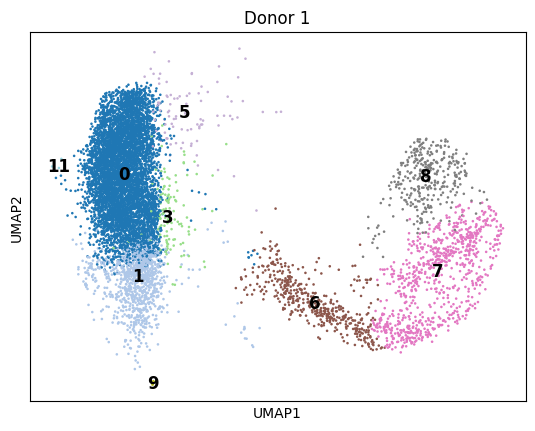

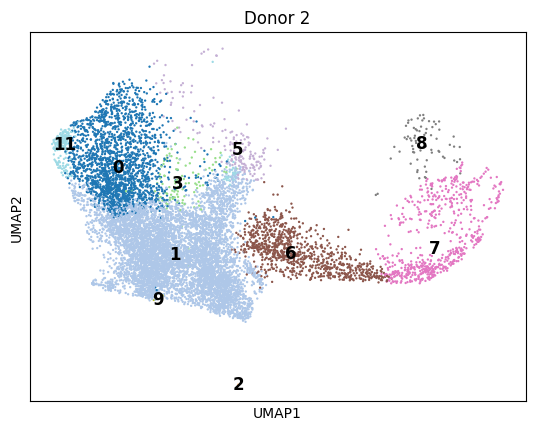

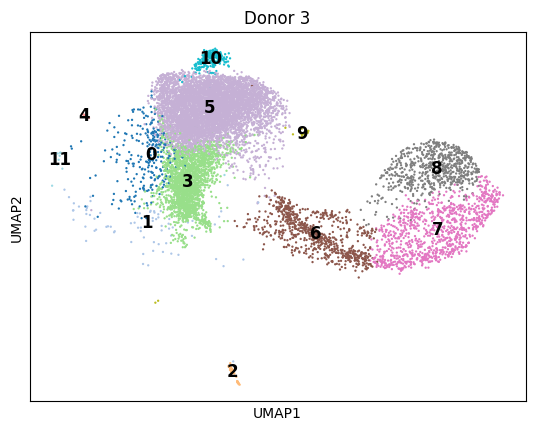

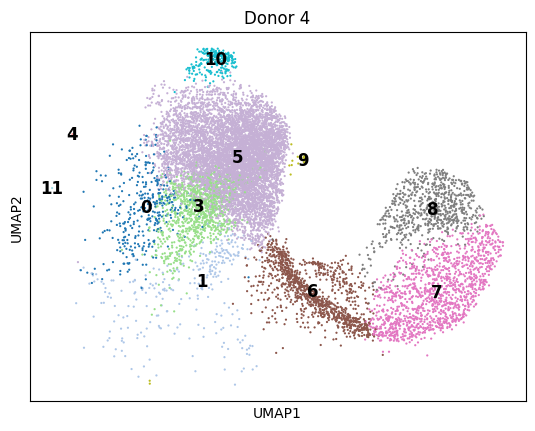

In [43]:
# separate by donor
umaps = ['Donor1', 'Donor2', 'Donor3', 'Donor4']

plot_data = []
for i in range(len(umaps)):
    plot_data.append(adata_combined[adata_combined.obs['donor'] == umaps[i], :].copy())

# for each AnnData, plot
for i in range(len(plot_data)):
    title = umaps[i][:-1] + ' ' + umaps[i][-1]
    sc.pl.umap(
        plot_data[i], 
        color='leiden', 
        title= title,
        legend_loc='on data',
        legend_fontsize=12,
        show=False # to save image first
    )
    plt.savefig(f"{title}_umap.png", dpi=300, bbox_inches='tight')

### Plotting for Figure 5

/usr2/collab/ryleighj/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


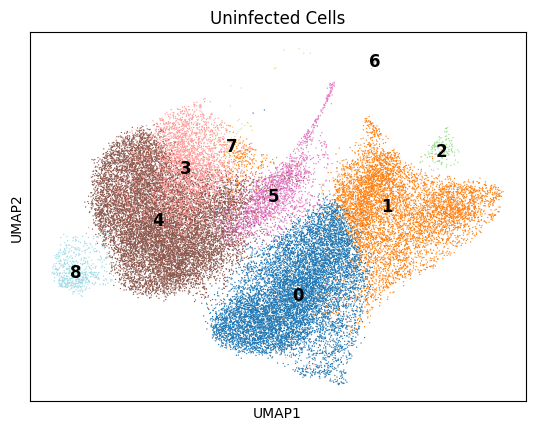

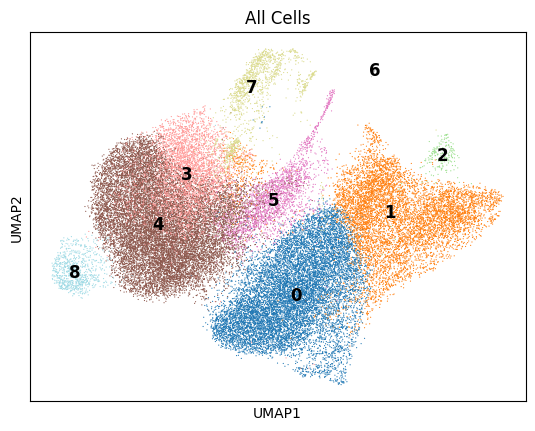

In [85]:
# plotting two umaps: one for uninfected cells and another for all cells

# subset for the cells that are uninfected
uninfected_cells = hosts_combined[hosts_combined.obs['pct_parasite'] < 2].copy()

cells = [uninfected_cells, hosts_combined]
titles = ['Uninfected Cells', 'All Cells']

for i in range(len(cells)):
    sc.pl.umap(
            cells[i], 
            color='leiden', 
            title= titles[i],
            legend_loc='on data',
            legend_fontsize=12,
            show=False # to save image first
        )
    plt.savefig(f"{titles[i]}_umap.png", dpi=300, bbox_inches='tight')

### EnrichR Pathway Analaysis on Cluster 7

tried running scanpy.tl.rank_genes_groups but am missing a layer of raw data counts....
tried to fix this in numerous steps of the code but doesn't seem to work, even with help from LLMs

Methods for the pathway analysis:
- extract the genes from cluster 7

In [ ]:
c7 = hosts_combined[hosts_combined.obs['leiden'] == '7', :].copy()
c7_genes = list(c7.var_names)

with open('c7genes.txt', 'w') as f:
    for g in c7_genes:
        f.write(g+'\n')  # export list of genes to copy and paste on EnrichR

In [71]:
## Run EnrichR online, then download table to results
import math

pathways = pd.read_csv('MSigDB_Hallmark_2020_table.txt', sep='\t')
pvals = list(pathways['P-value'])
neg_log10pval = list(map(lambda x: -1 * (math.log10(x)), pvals))
pathways['-log10pval'] = neg_log10pval

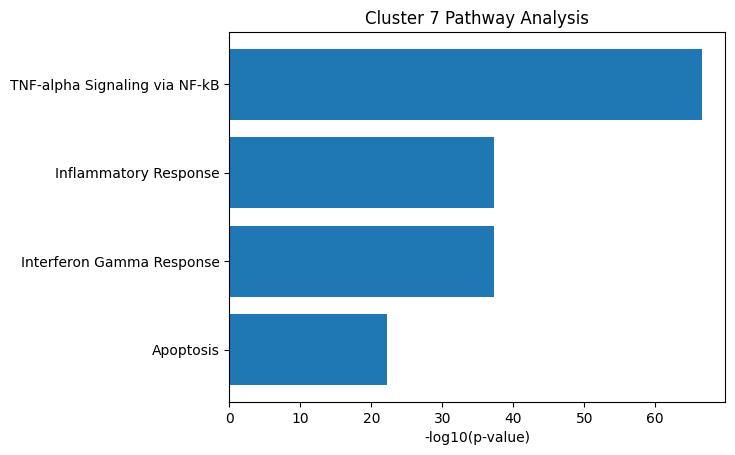

In [84]:
# make barplot of top 4 results
sig_pathways = pathways.head(4).sort_values(by='-log10pval', ascending=True)  # put most signifcant bar on the top

categories = sig_pathways['Term']
values = sig_pathways['-log10pval']

plt.barh(categories, values)
plt.title('Cluster 7 Pathway Analysis')
plt.xlabel('-log10(p-value)')
plt.savefig(f"pathway_analysis.png", dpi=300, bbox_inches='tight')